# Quora Insincere Questions Classification

kaggle link: https://www.kaggle.com/c/quora-insincere-questions-classification/overview
notebook link: https://www.kaggle.com/ashishpatel26/nlp-text-analytics-solution-quora

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

In this competition, Kagglers will develop models that identify and flag insincere questions. To date, Quora has employed both machine learning and manual review to address this problem. With your help, they can develop more scalable methods to detect toxic and misleading content.

Here's your chance to combat online trolls at scale. Help Quora uphold their policy of “Be Nice, Be Respectful” and continue to be a place for sharing and growing the world’s knowledge.

## Load packages and data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
import os
print(os.listdir("../Quora_Insincere_Questions_Classification"))

['.ipynb_checkpoints', 'Quora Insincere Questions Classification.ipynb', 'sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use

In [4]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm #tqdm is a package for Python that enables you to instantly create progress bars and estimate TTC (Time To Completion) for your functions and loops!
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

# keras and tensorflow.keras: https://datascience.stackexchange.com/questions/65736/why-does-keras-need-tensorflow-as-backend

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [5]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

In [6]:
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def split_text(x):
    x = wordninja.split(x)
    return '-'.join(x)

In [7]:
def load_and_prec():
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    
    train_df["question_text"] = train_df["question_text"].str.lower()
    test_df["question_text"] = test_df["question_text"].str.lower()
    
    train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_text(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))
    
    print("Train shape : ",train_df.shape)
    print(train_df.head(5))
    print("Test shape : ",test_df.shape)
    
    ## split to train and val
    train_df, val_df = train_test_split(train_df, test_size=0.001, random_state=2018) # hahaha


    ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    val_X = val_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values

    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['target'].values
    val_y = val_df['target'].values  
    
    #shuffling the data
    np.random.seed(2018)
    trn_idx = np.random.permutation(len(train_X))
    val_idx = np.random.permutation(len(val_X))

    train_X = train_X[trn_idx]
    val_X = val_X[val_idx]
    train_y = train_y[trn_idx]
    val_y = val_y[val_idx]    
    
    return train_X, val_X, test_X, train_y, val_y, tokenizer.word_index

## Load embeddings

We have four different types of embeddings.

GoogleNews-vectors-negative300 - https://code.google.com/archive/p/word2vec/
glove.840B.300d - https://nlp.stanford.edu/projects/glove/
paragram_300_sl999 - https://cogcomp.org/page/resource_view/106
wiki-news-300d-1M - https://fasttext.cc/docs/en/english-vectors.html

In [8]:
# Glove embeddings: https://nlp.stanford.edu/projects/glove/
def load_glove(word_index):
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

In [9]:
# fasttext: https://fasttext.cc/docs/en/english-vectors.html
def load_fasttext(word_index):    
    EMBEDDING_FILE = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [10]:
# Paragram-SL999: 300 dimensional Paragram embeddings tuned on SimLex999 dataset. https://www.cs.cmu.edu/~jwieting/
def load_para(word_index):
    EMBEDDING_FILE = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.0053247833,0.49346462
    embed_size = all_embs.shape[1]
    print(emb_mean,emb_std,"para")

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

## CNN Model

In [11]:
# https://www.kaggle.com/yekenot/2dcnn-textclassifier
def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

## Attention layer

In [12]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

## LSTM models

In [13]:
# CuDNNLSTM: Fast LSTM implementation backed by CuDNN. Can only be run on GPU, with the TensorFlow backend.
def model_lstm_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(maxlen)(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [14]:
def model_gru_ap_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x) # New
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model  

In [15]:
def model_lstm_du(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
def model_gru_atten_3(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(100, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

## Train and predict

In [ ]:
# https://www.kaggle.com/strideradu/word2vec-and-gensim-go-go-go
def train_pred(model, epochs=2):
    for e in range(epochs):
        model.fit(train_X, train_y, batch_size=512, epochs=1, validation_data=(val_X, val_y))
        pred_val_y = model.predict([val_X], batch_size=1024, verbose=0)
    pred_test_y = model.predict([test_X], batch_size=1024, verbose=0)
    # Plot training & validation accuracy values
#     plt.plot(model.history['acc'])
#     plt.plot(model.history['val_acc'])
#     plt.title('Model accuracy')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()

#     # Plot training & validation loss values
#     plt.plot(model.history.history['loss'])
#     plt.plot(model.history.history['val_loss'])
#     plt.title('Model loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()
    return pred_val_y, pred_test_y

## Main part: load, train, pred and blend

In [ ]:
train_X, val_X, test_X, train_y, val_y, word_index = load_and_prec()
vocab = []
for w,k in word_index.items():
    vocab.append(w)
    if k >= max_features:
        break
embedding_matrix_1 = load_glove(word_index)
# embedding_matrix_2 = load_fasttext(word_index)
embedding_matrix_3 = load_para(word_index)

In [ ]:
## Simple average: http://aclweb.org/anthology/N18-2031

# We have presented an argument for averaging as
# a valid meta-embedding technique, and found experimental
# performance to be close to, or in some cases 
# better than that of concatenation, with the
# additional benefit of reduced dimensionality  


## Unweighted DME in https://arxiv.org/pdf/1804.07983.pdf

# “The downside of concatenating embeddings and 
#  giving that as input to an RNN encoder, however,
#  is that the network then quickly becomes inefficient
#  as we combine more and more embeddings.”
  
# embedding_matrix = np.mean([embedding_matrix_1, embedding_matrix_2, embedding_matrix_3], axis = 0)
embedding_matrix = np.mean([embedding_matrix_1, embedding_matrix_3], axis = 0)
np.shape(embedding_matrix)

In [ ]:
outputs = []

In [ ]:
pred_val_y, pred_test_y = train_pred(model_gru_atten_3(embedding_matrix), epochs = 3)
outputs.append([pred_val_y, pred_test_y, '3 GRU w/ atten'])

In [ ]:
pred_val_y, pred_test_y = train_pred(model_gru_ap_atten(embedding_matrix), epochs = 3)
outputs.append([pred_val_y, pred_test_y, 'gru atten ap'])

In [ ]:
# pred_val_y, pred_test_y = train_pred(model_cnn(embedding_matrix), epochs = 2)
# outputs.append([pred_val_y, pred_test_y, '2d CNN'])

In [ ]:
pred_val_y, pred_test_y = train_pred(model_cnn(embedding_matrix_1), epochs = 3) # GloVe only
outputs.append([pred_val_y, pred_test_y, '2d CNN GloVe'])

In [ ]:
pred_val_y, pred_test_y = train_pred(model_lstm_du(embedding_matrix), epochs = 3)
outputs.append([pred_val_y, pred_test_y, 'LSTM DU'])

In [ ]:
pred_val_y, pred_test_y = train_pred(model_lstm_atten(embedding_matrix), epochs = 3)
outputs.append([pred_val_y, pred_test_y, '2 LSTM w/ attention'])

In [ ]:
pred_val_y, pred_test_y = train_pred(model_lstm_atten(embedding_matrix_1), epochs = 3) # Only GloVe
outputs.append([pred_val_y, pred_test_y, '2 LSTM w/ attention GloVe'])

In [ ]:
pred_val_y, pred_test_y = train_pred(model_lstm_atten(embedding_matrix_3), epochs = 3) # Only Para
outputs.append([pred_val_y, pred_test_y, '2 LSTM w/ attention Para'])

In [ ]:
# pred_test_y = np.sum([outputs[i][1] * weights[i] for i in range(len(outputs))], axis = 0)
coefs = [0.20076554,0.07993707,0.11611663,0.14885248,0.15734404,0.17454667,0.14288361]
# pred_test_y = np.mean([outputs[i][1] for i in range(len(outputs))], axis = 0)
pred_test_y = np.sum([outputs[i][1]*coefs[i] for i in range(len(coefs))], axis = 0)

pred_test_y = (pred_test_y > 0.34).astype(int)
test_df = pd.read_csv("../input/test.csv", usecols=["qid"])
out_df = pd.DataFrame({"qid":test_df["qid"].values})
out_df['prediction'] = pred_test_y
out_df.to_csv("submission.csv", index=False)

# Do Pretrained Embeddings Give You The Extra Edge?

link: https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge

Embeddings generally represent geometrical encodings of words based on how frequently appear together in a text corpus. Various implementations of word embeddings described below differs in the way as how they are constructed.

Word2Vec

The main idea behind it is that you train a model on the context on each word, so similar words will have similar numerical representations.

Just like a normal feed-forward densely connected neural network(NN) where you have a set of independent variables and a target dependent variable that you are trying to predict, you first break your sentence into words(tokenize) and create a number of pairs of words, depending on the window size. So one of the combination could be a pair of words such as ('cat','purr'), where cat is the independent variable(X) and 'purr' is the target dependent variable(Y) we are aiming to predict.

We feed the 'cat' into the NN through an embedding layer initialized with random weights, and pass it through the softmax layer with ultimate aim of predicting 'purr'. The optimization method such as SGD minimize the loss function "(target word | context words)" which seeks to minimize the loss of predicting the target words given the context words. If we do this with enough epochs, the weights in the embedding layer would eventually represent the vocabulary of word vectors, which is the "coordinates" of the words in this geometric vector space.

GLOVE

GLOVE works similarly as Word2Vec. While you can see above that Word2Vec is a "predictive" model that predicts context given word, GLOVE learns by constructing a co-occurrence matrix (words X context) that basically count how frequently a word appears in a context. Since it's going to be a gigantic matrix, we factorize this matrix to achieve a lower-dimension representation. There's a lot of details that goes in GLOVE but that's the rough idea. (use SVD to decompose the matrix).

FastText

FastText is quite different from the above 2 embeddings. While Word2Vec and GLOVE treats each word as the smallest unit to train on, FastText uses n-gram characters as the smallest unit. For example, the word vector ,"apple", could be broken down into separate word vectors units as "ap","app","ple". The biggest benefit of using FastText is that it generate better word embeddings for rare words, or even words not seen during training because the n-gram character vectors are shared with other words. This is something that Word2Vec and GLOVE cannot achieve.

Load Embedding function

The function  would return a new embedding matrix that has the loaded weights from the pretrained embeddings for the common words we have, and randomly initialized numbers that has the same mean and standard deviation for the rest of the weights in this matrix.

In [ ]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="glove"):
            EMBEDDING_FILE='../input/glove-twitter/glove.twitter.27B.25d.txt'
            embed_size = 25
        elif(typeToLoad=="word2vec"):
            word2vecDict = word2vec.KeyedVectors.load_word2vec_format("../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin", binary=True)
            embed_size = 300
        elif(typeToLoad=="fasttext"):
            EMBEDDING_FILE='../input/fasttext/wiki.simple.vec'
            embed_size = 300

        if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
            embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
            f = open(EMBEDDING_FILE)
            for line in f:
                #split up line into an indexed array
                values = line.split()
                #first index is word
                word = values[0]
                #store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs #50 dimensions
            f.close()
            print('Loaded %s word vectors.' % len(embeddings_index))
        else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

## Bidirectional LSTM

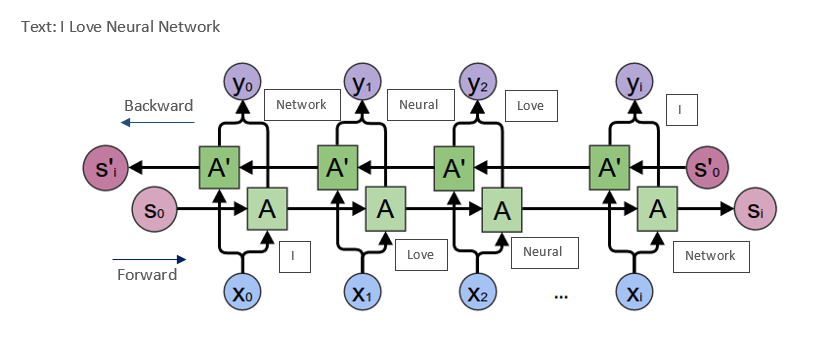

Imagine that the LSTM is split between 2 hidden states for each time step. As the sequence of words is being feed into the LSTM in a forward fashion, there's another reverse sequence that is feeding to the different hidden state at the same time. You might noticed later at the model summary that the output dimension of LSTM layer has doubled to 120 because 60 dimensions are used for forward, and another 60 are used for reverse.

The greatest advantage in using Bidirectional LSTM is that when it runs backwards you preserve information from the future and using the two hidden states combined, you are able in any point in time to preserve information from both past and future.

## LSTM Drop out and recurrent drop out

Why are we using dropout? You might have noticed that it's easy for LSTM to overfit, and in my previous notebook, overfitting problem starts to surface in just 2 epochs! Drop out is not something new to most of us, and these mechanisms applies the same dropout principles in a LSTM context.

LSTM Dropout is a probabilistic drop out layer on the inputs in each time step. On the other hand, recurrent drop out is something like a dropout mask that applies drop out between the hidden states throughout the recursion of the whole LSTM network.

# Improve your Score with Text Preprocessing

link: https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing
link: https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2
How to: Preprocessing when using embeddings: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

In [ ]:
import pandas as pd
import numpy as np
import operator 
import re
import gc
import keras
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [ ]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
df = pd.concat([train ,test])

In [ ]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [ ]:
glove = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
print("Extracting GloVe embedding")
embed_glove = load_embed(glove)

Vocabulary and Coverage functions

In [ ]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [ ]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [ ]:
vocab = build_vocab(df['question_text'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

Glove : 
Found embeddings for 32.773% of vocab
Found embeddings for  88.149% of all text

Apply lowerization (necessary if using paragram): Fasttext and GloVe understand capitalization, but you still win a bit.

In [ ]:
df['lowered_question'] = df['question_text'].apply(lambda x: x.lower(

If you apply lowerization, you lost a bit of informations on other embeddings :
Therer are words known that are known with upper letters and unknown without. Let us fix that :

word.lower() takes the embedding of word if word.lower() doesn't have an embedding

In [ ]:
def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

In [ ]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
add_lower(embed_glove, vocab)
oov_glove = check_coverage(vocab, embed_glove)

Glove : 
Found embeddings for 32.773% of vocab
Found embeddings for  88.149% of all text
Added 15199 words to embedding
Found embeddings for 33.029% of vocab
Found embeddings for  88.164% of all text

In [ ]:
oov_glove[:10]

[('India?', 17082),
 ('it?', 13436),
 ("What's", 12985),
 ('do?', 9112),
 ('life?', 8074),
 ('you?', 6553),
 ('me?', 6485),
 ('them?', 6421),
 ('time?', 5994),
 ('world?', 5632)]

First faults appearing are :
Contractions
Words with punctuation in them
Let us correct that.

Contractions

In [17]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [ ]:
def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known

In [ ]:
print("- Known Contractions -")
print("   Glove :")
print(known_contractions(embed_glove))

- Known Contractions -
   Glove :
["can't", "'cause", "didn't", "doesn't", "don't", "I'd", "I'll", "I'm", "I've", "i'd", "i'll", "i'm", "i've", "it's", "ma'am", "o'clock", "that's", "you'll", "you're"]

Not a lot of contractions are known. (FastText knows none)
We use the map to replace them

In [ ]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [ ]:
df['treated_question'] = df['lowered_question'].apply(lambda x: clean_contractions(x, contraction_mapping))

In [ ]:
vocab = build_vocab(df['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

Glove : 
Found embeddings for 30.534% of vocab
Found embeddings for  88.563% of all text

Now, let us deal with special characters

In [ ]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [ ]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [ ]:
print("Glove :")
print(unknown_punct(embed_glove, punct))

Glove :
“ ” ’ ∞ θ ÷ α • à − β ∅ ³ π ‘ ₹ ´ ° £ € × ™ √ ² — – 

Some characters are unknown.
We use a map to replace unknown characters with known ones.

We make sure there are spaces between words and punctuation

In [ ]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [ ]:
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [ ]:
df['treated_question'] = df['treated_question'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

In [ ]:
vocab = build_vocab(df['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

Glove : 
Found embeddings for 69.098% of vocab
Found embeddings for  99.577% of all text

In [ ]:
oov_glove[:100]

[('quorans', 885),
 ('brexit', 542),
 ('cryptocurrencies', 525),
 ('redmi', 398),
 ('coinbase', 150),
 ('oneplus', 144),
 ('uceed', 126),
 ('demonetisation', 118),
 ('bhakts', 118),
 ('upwork', 117),
 ('pokémon', 117),
 ('machedo', 112),
 ('gdpr', 110),
 ('adityanath', 108),
 ('bnbr', 105),
 ('boruto', 105),
 ('alshamsi', 100),
 ('dceu', 94),
 ('iiest', 91),
 ('litecoin', 90),
 ('unacademy', 89),
 ('sjws', 89),
 ('zerodha', 85),
 ('qoura', 85),
 ('tensorflow', 82),
 ('fiancé', 76),
 ('lnmiit', 73),
 ('kavalireddi', 71),
 ('doklam', 70),
 ('muoet', 68),
 ('nicmar', 66),
 ('vajiram', 62),
 ('srmjee', 61),
 ('adhaar', 60),
 ('altcoin', 59),
 ('zebpay', 58),
 ('elitmus', 58),
 ('jiren', 56),
 ('altcoins', 56),
 ('awdhesh', 55),
 ('hackerrank', 54),
 ('ryzen', 51),
 ('koinex', 50),
 ('baahubali', 48),
 ('mhcet', 47),
 ('byju', 47),
 ('binance', 46),
 ('srmjeee', 44),
 ('beerus', 43),
 ('ftre', 42),
 ('skripal', 42),
 ('sgsits', 42),
 ('mhtcet', 40),
 ('hotstar', 40),
 ('gurugram', 40),
 ('bipc', 39),
 ('lbsnaa', 38),
 ('bmsce', 38),
 ('jiofi', 38),
 ('nanodegree', 38),
 ('sarahah', 36),
 ('ravula', 36),
 ('microservices', 36),
 ('swachh', 36),
 ('obor', 35),
 ('usict', 34),
 ('patreon', 34),
 ('reactjs', 34),
 ('clickbait', 34),
 ('zenfone', 33),
 ('iisers', 33),
 ('bittrex', 32),
 ('chromecast', 32),
 ('pessat', 31),
 ('diestm', 31),
 ('jungkook', 30),
 ('xxxtentacion', 30),
 ('dream11', 30),
 ('demonitisation', 30),
 ('kalpit', 29),
 ('bitconnect', 29),
 ('mmmut', 29),
 ('aktu', 29),
 ('deepmind', 28),
 ('airpods', 28),
 ('trumpcare', 28),
 ('onedrive', 27),
 ('rlwl', 27),
 ('aiats', 27),
 ('hbtu', 26),
 ('zamasu', 26),
 ('codeforces', 26),
 ('wannacry', 26),
 ('irodov', 25),
 ('despacito', 25),
 ('simpliv', 25),
 ('são', 25),
 ('nlus', 25),
 ('vssut', 25),
 ('electroneum', 24)]

What's still missing ?
Unknown words
Acronyms
Spelling mistakes

We can correct manually most frequent mispells
For example, here are some mistakes and their frequency¶
qoura : 85 times
mastrubation : 38 times
demonitisation : 30 times
…

In [ ]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}

In [ ]:
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [ ]:
df['treated_question'] = df['treated_question'].apply(lambda x: correct_spelling(x, mispell_dict))

In [ ]:
vocab = build_vocab(df['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

Glove : 
Found embeddings for 69.095% of vocab
Found embeddings for  99.579% of all text

Applying treatment

In [ ]:
# Lowering
train['treated_question'] = train['question_text'].apply(lambda x: x.lower())
# Contractions
train['treated_question'] = train['treated_question'].apply(lambda x: clean_contractions(x, contraction_mapping))
# Special characters
train['treated_question'] = train['treated_question'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))
# Spelling mistakes
train['treated_question'] = train['treated_question'].apply(lambda x: correct_spelling(x, mispell_dict))

Data for the network

In [ ]:
len_voc = 95000
max_len = 60
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
def make_data(X):
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(X)
    X = t.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=max_len)
    return X, t.word_index

In [ ]:
X, word_index = make_data(train['question_text'])

In [ ]:
def make_treated_data(X):
    t = Tokenizer(num_words=len_voc, filters='')
    t.fit_on_texts(X)
    X = t.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=max_len)
    return X, t.word_index

In [ ]:
X_treated, word_index_treated = make_data(train['treated_question'])

In [ ]:
from sklearn.model_selection import train_test_split
y = train['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=420)
X_t_train, X_t_val, _, _ = train_test_split(X_treated, y, test_size=0.1, random_state=420)
print(f"Training on {X_train.shape[0]} texts")

Training on 1175509 texts

Embeddings
I use GloVe here, because I got better results with it than with others. But feel free to change that.

In [ ]:
def make_embed_matrix(embeddings_index, word_index, len_voc):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [ ]:
embedding = make_embed_matrix(embed_glove, word_index, len_voc)

del word_index
gc.collect()

In [ ]:
embedding_treated = make_embed_matrix(embed_glove, word_index_treated, len_voc)
del word_index_treated
gc.collect()

f1 metric for Keras

In [ ]:
from keras import backend as K

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Model

In [ ]:
from keras.models import Model
from keras.layers import Dense, Embedding, Bidirectional, CuDNNGRU, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Input, Dropout
from keras.optimizers import Adam

In [ ]:
def make_model(embedding_matrix, embed_size=300, loss='binary_crossentropy'):
    inp    = Input(shape=(max_len,))
    x      = Embedding(len_voc, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x      = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    x      = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pl = GlobalAveragePooling1D()(x)
    max_pl = GlobalMaxPooling1D()(x)
    concat = concatenate([avg_pl, max_pl])
    dense  = Dense(64, activation="relu")(concat)
    drop   = Dropout(0.1)(concat)
    output = Dense(1, activation="sigmoid")(concat)
    
    model  = Model(inputs=inp, outputs=output)
    model.compile(loss=loss, optimizer=Adam(lr=0.0001), metrics=['accuracy', f1])
    return model

In [ ]:
model = make_model(embedding)
model_treated = make_model(embedding_treated)
model.summary()

Callbacks

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
checkpoints = ModelCheckpoint('weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)

In [ ]:
checkpoints_treated = ModelCheckpoint('treated_weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)
reduce_lr_treated = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)

Fitting

In [ ]:
epochs = 8
batch_size = 512

In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=[X_val, y_val], callbacks=[checkpoints, reduce_lr])

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.show()

In [ ]:
history = model_treated.fit(X_t_train, y_train, batch_size=batch_size, epochs=epochs, 
                            validation_data=[X_t_val, y_val], callbacks=[checkpoints_treated, reduce_lr_treated])

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.show()

In [ ]:
model.load_weights('weights.hdf5')
model_treated.load_weights('treated_weights.hdf5')

Results

In [ ]:
pred_val = model.predict(X_val, batch_size=512, verbose=1)
pred_t_val = model_treated.predict(X_t_val, batch_size=512, verbose=1)

F1 Scores

In [ ]:
from sklearn.metrics import f1_score
def tweak_threshold(pred, truth):
    thresholds = []
    scores = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        thresholds.append(thresh)
        score = f1_score(truth, (pred>thresh).astype(int))
        scores.append(score)
    return np.max(scores), thresholds[np.argmax(scores)]

In [ ]:
score_val, threshold_val = tweak_threshold(pred_val, y_val)

print(f"Scored {round(score_val, 4)} for threshold {threshold_val} with untreated texts on validation data")

In [ ]:
score_t_val, threshold_t_val = tweak_threshold(pred_t_val, y_val)

print(f"Scored {round(score_t_val, 4)} for threshold {threshold_t_val} with treated texts on validation data")

# cyclical learning rate policy (CLR)

link: https://www.kaggle.com/hireme/fun-api-keras-f1-metric-cyclical-learning-rate/code

In [ ]:
# BASED ON https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings

import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn import metrics

from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, GlobalAvgPool1D, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Optimizer
from keras.callbacks import *

import tensorflow as tf

train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

## Parameters 
embed_size = 300 # how big is each word vector
max_features = 55000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 27 # max number of words in a question to use
batch_size = 10000
drop_ratio = 0.13
opt = 'adam'

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_df['target'].values




class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
    

def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    

clr = CyclicLR(base_lr=0.001, max_lr=0.007,
                        step_size=300., mode='exp_range',
                        gamma=0.99994)


inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNGRU(200, return_sequences=True))(x)
x1 = GlobalMaxPool1D()(x)
x2 = GlobalAvgPool1D()(x)
x = concatenate([x1,x2])
x = Dense(16, activation="elu")(x)
x = Dropout(drop_ratio)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1])
model.fit(train_X, train_y, batch_size=batch_size, epochs=2, callbacks = [clr,])

pred_noemb_test_y = model.predict([test_X], batch_size=1024, verbose=1)

del model, inp, x
import gc; gc.collect()
time.sleep(10)


#### Glove
EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(200, return_sequences=True))(x)
x1 = GlobalMaxPool1D()(x)
x2 = GlobalAvgPool1D()(x)
x = concatenate([x1,x2])
x = Dense(16, activation="elu")(x)
x = Dropout(drop_ratio)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1])
model.fit(train_X, train_y, batch_size=batch_size, epochs=2, callbacks = [clr,])
pred_glove_test_y = model.predict([test_X], batch_size=1024, verbose=1)

del word_index, embeddings_index, all_embs, embedding_matrix, model, inp, x
import gc; gc.collect()
time.sleep(10)

#### WIKI
EMBEDDING_FILE = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(200, return_sequences=True))(x)
x1 = GlobalMaxPool1D()(x)
x2 = GlobalAvgPool1D()(x)
x = concatenate([x1,x2])
x = Dense(16, activation="elu")(x)
x = Dropout(drop_ratio)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=opt,  metrics=[f1])
model.fit(train_X, train_y, batch_size=batch_size, epochs=2, callbacks = [clr,])
pred_fasttext_test_y = model.predict([test_X], batch_size=1024, verbose=1)

del word_index, embeddings_index, all_embs, embedding_matrix, model, inp, x
import gc; gc.collect()
time.sleep(10)


### Paragram Embeddings:
EMBEDDING_FILE = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(200, return_sequences=True))(x)
x1 = GlobalMaxPool1D()(x)
x2 = GlobalAvgPool1D()(x)
x = concatenate([x1,x2])
x = Dense(16, activation="elu")(x)
x = Dropout(drop_ratio)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',  optimizer=opt,  metrics=[f1])
model.fit(train_X, train_y, batch_size=batch_size, epochs=2, callbacks = [clr,])
pred_paragram_test_y = model.predict([test_X], batch_size=1024, verbose=1)

del word_index, embeddings_index, all_embs, embedding_matrix, model, inp, x
import gc; gc.collect()
time.sleep(10)

####

pred_test_y = 0.32*pred_glove_test_y + 0.32*pred_fasttext_test_y + 0.32*pred_paragram_test_y + 0.04*pred_noemb_test_y
pred_test_y = (pred_test_y>0.31).astype(int)
out_df = pd.DataFrame({"qid":test_df["qid"].values})
out_df['prediction'] = pred_test_y
out_df.to_csv("submission.csv", index=False)

# Capsule networks

link: https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-capsule-networks

What is the advantage?
In a CNN, there are pooling layers. We generally use MaxPool which is a very primitive type of routing mechanism. The most active feature in a local pool (say 4x4 grid) is routed to the higher layer and the higher-level detectors don't have a say in the routing. Compare this with the routing-by-agreement mechanism introduced in the CapsNet. Only those features that agree with high-level detectors are routed. This is the advantage of CapsNet over CNN. It has a superior dynamic routing mechanism (dynamic because the information to be routed is determined in real time).

Advantage of Capsule Layer in Text Classification
As you can see, we have used Capsule layer instead of Pooling layer. Capsule Layer eliminates the need for forced pooling layers like MaxPool. In many cases, this is desired because we get translational invariance without losing minute details.

Capsule Network Model
The Architecture of our CapsNet is very similar to general architecture, except for an addition Capsule Layer.

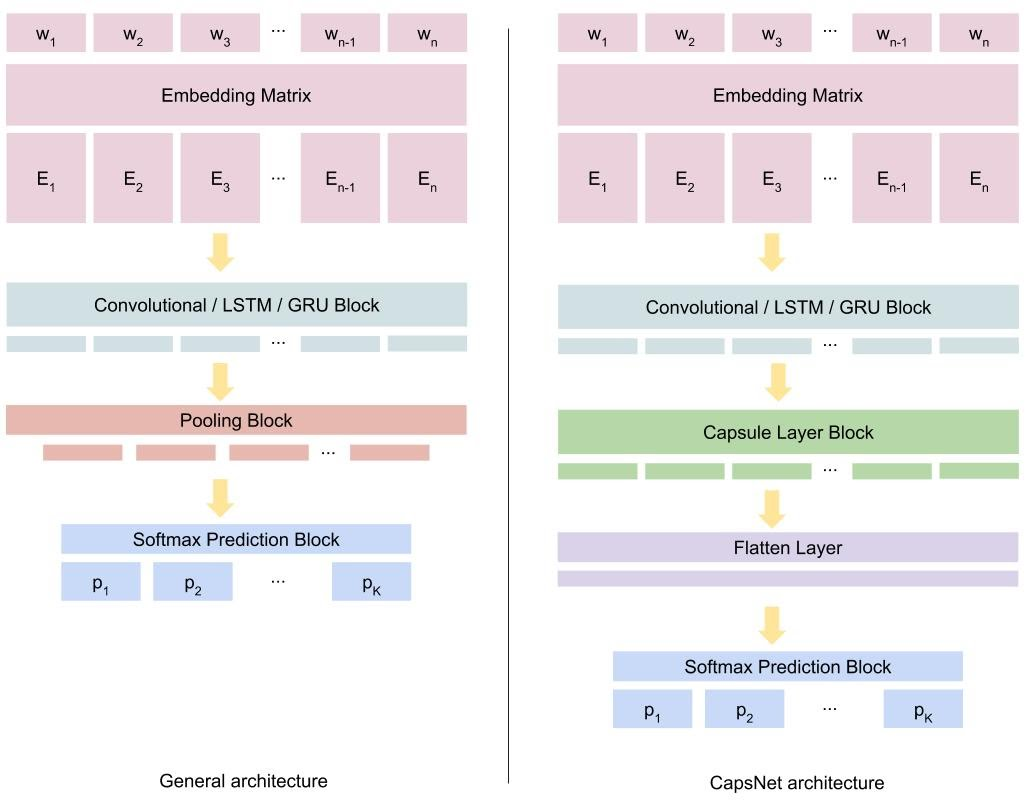

Stacked Capsule Autoencoders: unsupervised version of capsule network

paper link: https://arxiv.org/pdf/1906.06818.pdf